[View in Colaboratory](https://colab.research.google.com/github/sungreong/TIL/blob/master/iris_conditional_gan_%EC%8B%A4%ED%8C%A8.ipynb)

In [0]:
!pip install -q keras

In [4]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt

import sys

import numpy as np
from keras import backend as K

Using TensorFlow backend.


In [5]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :]  
y = iris.target
print(np.expand_dims(X,axis=1)[0].shape)

(X_train, y_train), (_, _) = mnist.load_data()
print(X_train[0].shape)


(1, 4)
11493376/11490434 [==============================] - 3s 0us/step
(28, 28)


In [6]:
print(X.shape , y.shape)
print(y[0:10])
np.unique(y)

(150, 4) (150,)
[0 0 0 0 0 0 0 0 0 0]


array([0, 1, 2])

In [7]:
(1, 4, 1)

(1, 4, 1)

In [0]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 1
        self.img_cols = 4
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 3
        self.latent_dim = 4

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(4,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(100, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(200))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(300))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=10, sample_interval=5):

        # Load the dataset
        X_train = iris.data[:, :]
        X_train.apply(lambda x: (x - np.mean(x) )/np.std(x) , axis=1)
        y_train = iris.target

        # Configure input
        X_train = np.expand_dims(X_train, axis=1)
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]


            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 4))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch %  sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        noise = np.random.normal(0, 10, (1, 4 ))
        sampled_labels = np.arange(0, 3).reshape(-1, 1)

        zero_1 = self.generator.predict([noise, sampled_labels[0]])
        one_1 = self.generator.predict([noise, sampled_labels[1]])
        two_1 = self.generator.predict([noise, sampled_labels[2]])
        zero.append(zero_1)
        one.append(one_1)
        two.append(two_1)
        

        # Rescale images 0 - 1
        

In [13]:
if __name__ == '__main__':
    cgan = CGAN()
    zero=list()
    one= list()
    two = list()
    cgan.train(epochs=1000, batch_size=10, sample_interval=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               2560      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
__________

AttributeError: ignored

In [0]:

a=np.resize(zero,(200,4))

b=np.resize(two,(200,4))

c=np.resize(one,(200,4))


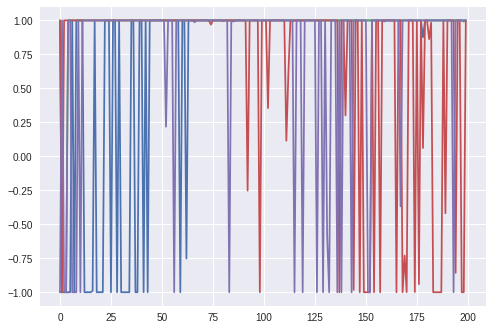

In [11]:
plt.plot(a)
plt.show()

AttributeError: ignored